In [1]:
# from google.colab import drive
import zipfile
import sys
import h5py
import numpy as np
import os
from PIL import Image
import pandas as pd
import logging
import json
import tensorflow as tf
import itertools
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, Dense, MaxPooling2D, Dropout, Flatten, BatchNormalization, Activation, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Precision, Accuracy, Recall
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras import layers, Model
# from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.models import load_model

# import keras
from keras.utils import to_categorical
from keras.models import load_model
from keras.preprocessing.image import array_to_img
# from keras.callbacks import EarlyStopping, ModelCheckpoint, Callback
# from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

# import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, accuracy_score, f1_score, recall_score, confusion_matrix
from sklearn.preprocessing import OneHotEncoder

# import matplotlib
%matplotlib inline
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import seaborn as sns

import csv
import visualkeras
np.random.seed(42)

2024-06-07 23:20:38.831861: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
print("Python version:", sys.version) # needs to import sys
print("Numpy version:", np.__version__)
print("Pillow version:", Image.__version__)
print("pandas version:", pd.__version__)
print("h5py version:", h5py.__version__)
print("TensorFlow version:", tf.__version__)
# print("Itertools version:", itertools.__version__)  # part of python library
# print("Keras version:", keras.__version__)  # needs to import keras
# print("sklearn version:", sklearn.__version__)  # needs to import sklearn
# print("matplotlib version:", matplotlib.__version__)  # needs to import matplotlib
print("seaborn version:", sns.__version__)

Python version: 3.10.12 (main, Jul  5 2023, 15:34:07) [Clang 14.0.6 ]
Numpy version: 1.25.2
Pillow version: 9.4.0
pandas version: 1.5.3
h5py version: 3.9.0
TensorFlow version: 2.15.0
seaborn version: 0.13.1


# Create Constants

In [2]:
# LABEL_NAMES = ['Aceh_Pintu_Aceh', 'Bali_Barong', 'Bali_Merak', 'DKI_Ondel_Ondel', 'JawaBarat_Megamendung', 'JawaTimur_Pring', 'Kalimantan_Dayak', 'Lampung_Gajah', 'Madura_Mataketeran', 'Maluku_Pala', 'NTB_Lumbung', 'Papua_Asmat', 'Papua_Cendrawasih', 'Papua_Tifa', 'Solo_Parang', 'SulawesiSelatan_Lontara', 'SumateraBarat_Rumah_Minang', 'SumateraUtara_Boraspati', 'Yogyakarta_Kawung', 'Yogyakarta_Parang']
LABEL_NAMES = ['Aceh', 'Bali', 'Betawi', 'Ciamis', 'Cirebon', 'Garut', 'Kalimantan_Dayak', 'Kalimantan_Pontianak', 'Kulon Progo_Geblek Renteng', 'Madura', 'Maluku_Pala Cengkeh', 'Papua_Cendrawasih', 'Pati', 'Pekalongan', 'Solo_Sidoluhur', 'Solo_Sogan', 'Tasikmalaya_Priyangan', 'Yogyakarta_Kawung', 'Yogyakarta_Sekar Jagad', 'Yogyakarta_Tambal']
IMAGE_WIDTH = 224
IMAGE_HEIGHT = 224
IMAGE_PIXELS = IMAGE_WIDTH * IMAGE_HEIGHT
COLOR_CHANNELS = 3
TOTAL_INPUTS = IMAGE_PIXELS * COLOR_CHANNELS
NO_CLASSES = 20
BATCH_SIZE = 32

VALIDATION_SIZE = 6
TESTING_SIZE = 8


# Data Gathering

In [3]:
# Directory containing the data
# DATA_DIR = "/content/aug_batik_v2"
DATA_DIR = "/Users/merchika/chikaData/TA/another_dataset/undersampling_augmented_dataset"

# rescale pixel values to [0, 1] at later stage
# common_datagen = ImageDataGenerator()

common_datagen = ImageDataGenerator()

# Set up data generators for training, validation, and testing
train_generator = common_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, "train"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),  # Set the target image size
    color_mode='rgb', # Set color mode to RGB
    class_mode='categorical'  # For multi classes
)

validation_generator = common_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, "validation"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb', # Set color mode to RGB
    class_mode='categorical'
)

test_generator = common_datagen.flow_from_directory(
    directory=os.path.join(DATA_DIR, "test"),
    target_size=(IMAGE_HEIGHT, IMAGE_WIDTH),
    color_mode='rgb', # Set color mode to RGB
    class_mode='categorical'
)

# Print class labels
print("Class labels:")
print(train_generator.class_indices)

Found 12817 images belonging to 20 classes.
Found 1266 images belonging to 20 classes.
Found 1582 images belonging to 20 classes.
Class labels:
{'Aceh': 0, 'Bali': 1, 'Betawi': 2, 'Ciamis': 3, 'Cirebon': 4, 'Garut': 5, 'Kalimantan_Dayak': 6, 'Kalimantan_Pontianak': 7, 'Kulon Progo_Geblek Renteng': 8, 'Madura': 9, 'Maluku_Pala Cengkeh': 10, 'Papua_Cendrawasih': 11, 'Pati': 12, 'Pekalongan': 13, 'Solo_Sidoluhur': 14, 'Solo_Sogan': 15, 'Tasikmalaya_Priyangan': 16, 'Yogyakarta_Kawung': 17, 'Yogyakarta_Sekar Jagad': 18, 'Yogyakarta_Tambal': 19}


# Data Exploration

## Train Dataset

In [4]:
num_images = train_generator.n
num_classes = train_generator.num_classes
print(f"Number of images: {train_generator.n}")
print(f"Number of classes:{train_generator.num_classes}")

Number of images: 12817
Number of classes:20


In [5]:
class_indices = train_generator.class_indices
y_train_class_names = {v: k for k, v in class_indices.items()}
print("Class names:", y_train_class_names)

Class names: {0: 'Aceh', 1: 'Bali', 2: 'Betawi', 3: 'Ciamis', 4: 'Cirebon', 5: 'Garut', 6: 'Kalimantan_Dayak', 7: 'Kalimantan_Pontianak', 8: 'Kulon Progo_Geblek Renteng', 9: 'Madura', 10: 'Maluku_Pala Cengkeh', 11: 'Papua_Cendrawasih', 12: 'Pati', 13: 'Pekalongan', 14: 'Solo_Sidoluhur', 15: 'Solo_Sogan', 16: 'Tasikmalaya_Priyangan', 17: 'Yogyakarta_Kawung', 18: 'Yogyakarta_Sekar Jagad', 19: 'Yogyakarta_Tambal'}


In [6]:
num_classes = len(class_indices)
y_train_labels = [y_train_class_names[i] for i in range(num_classes)]
print(y_train_labels)

['Aceh', 'Bali', 'Betawi', 'Ciamis', 'Cirebon', 'Garut', 'Kalimantan_Dayak', 'Kalimantan_Pontianak', 'Kulon Progo_Geblek Renteng', 'Madura', 'Maluku_Pala Cengkeh', 'Papua_Cendrawasih', 'Pati', 'Pekalongan', 'Solo_Sidoluhur', 'Solo_Sogan', 'Tasikmalaya_Priyangan', 'Yogyakarta_Kawung', 'Yogyakarta_Sekar Jagad', 'Yogyakarta_Tambal']


In [7]:
import PIL.Image
from PIL import UnidentifiedImageError

x_train_all = []
y_train_all = []

# Looping
# for _ in range(num_images // BATCH_SIZE + 1):
#     x_batch, y_batch = next(train_generator)
#     x_train_all.append(x_batch)
#     y_train_all.append(y_batch)

for _ in range(num_images // BATCH_SIZE + 1):
    try:
        x_batch, y_batch = next(train_generator)
        x_train_all.append(x_batch)
        y_train_all.append(y_batch)
    except UnidentifiedImageError as e:
        print("Error loading image:", e)

# Concatenate
x_train = np.concatenate(x_train_all, axis=0)
y_train = np.concatenate(y_train_all, axis=0)

# Display the shapes of x and y_train
print("x_train shape:", x_train.shape)
print("y_train shape:", y_train.shape)

x_train shape: (12817, 224, 224, 3)
y_train shape: (12817, 20)


In [8]:
no_images, x, y, c = x_train.shape
print(f"images = {no_images} \t| width = {x} \t| height = {y} \t| channels = {c} \t")

images = 12817 	| width = 224 	| height = 224 	| channels = 3 	


## Validation Dataset

In [9]:
val_num_images = validation_generator.n
val_num_classes = validation_generator.num_classes
print(f"Number of images: {validation_generator.n}")
print(f"Number of classes:{validation_generator.num_classes}")

Number of images: 1266
Number of classes:20


In [10]:
class_indices = validation_generator.class_indices
y_val_class_names = {v: k for k, v in class_indices.items()}
print("Class names:", y_val_class_names)

Class names: {0: 'Aceh', 1: 'Bali', 2: 'Betawi', 3: 'Ciamis', 4: 'Cirebon', 5: 'Garut', 6: 'Kalimantan_Dayak', 7: 'Kalimantan_Pontianak', 8: 'Kulon Progo_Geblek Renteng', 9: 'Madura', 10: 'Maluku_Pala Cengkeh', 11: 'Papua_Cendrawasih', 12: 'Pati', 13: 'Pekalongan', 14: 'Solo_Sidoluhur', 15: 'Solo_Sogan', 16: 'Tasikmalaya_Priyangan', 17: 'Yogyakarta_Kawung', 18: 'Yogyakarta_Sekar Jagad', 19: 'Yogyakarta_Tambal'}


In [11]:
num_classes = len(class_indices)
y_val_labels = [y_val_class_names[i] for i in range(num_classes)]
print(y_val_labels)

['Aceh', 'Bali', 'Betawi', 'Ciamis', 'Cirebon', 'Garut', 'Kalimantan_Dayak', 'Kalimantan_Pontianak', 'Kulon Progo_Geblek Renteng', 'Madura', 'Maluku_Pala Cengkeh', 'Papua_Cendrawasih', 'Pati', 'Pekalongan', 'Solo_Sidoluhur', 'Solo_Sogan', 'Tasikmalaya_Priyangan', 'Yogyakarta_Kawung', 'Yogyakarta_Sekar Jagad', 'Yogyakarta_Tambal']


In [12]:
x_val_all = []
y_val_all = []

# print(val_num_images)
# print(val_num_images // BATCH_SIZE + 1)

# Looping
for _ in range(val_num_images // BATCH_SIZE + 1):
    x_val_batch, y_val_batch = next(validation_generator)
    x_val_all.append(x_val_batch)
    y_val_all.append(y_val_batch)

# Concatenate
x_val = np.concatenate(x_val_all, axis=0)
y_val = np.concatenate(y_val_all, axis=0)

# Display the shapes of x and y_train
print("x_val shape:", x_val.shape)
print("y_val shape:", y_val.shape)

x_val shape: (1266, 224, 224, 3)
y_val shape: (1266, 20)


In [13]:
no_images, x, y, c = x_val.shape
print(f"images = {no_images} \t| width = {x} \t| height = {y} \t| channels = {c} \t")

images = 1266 	| width = 224 	| height = 224 	| channels = 3 	


## Test Dataset

In [14]:
test_num_images = test_generator.n
test_num_classes = test_generator.num_classes
print(f"Number of images: {test_generator.n}")
print(f"Number of classes:{test_generator.num_classes}")

Number of images: 1582
Number of classes:20


In [15]:
class_indices = test_generator.class_indices
y_test_class_names = {v: k for k, v in class_indices.items()}
print("Class names:", y_test_class_names)

Class names: {0: 'Aceh', 1: 'Bali', 2: 'Betawi', 3: 'Ciamis', 4: 'Cirebon', 5: 'Garut', 6: 'Kalimantan_Dayak', 7: 'Kalimantan_Pontianak', 8: 'Kulon Progo_Geblek Renteng', 9: 'Madura', 10: 'Maluku_Pala Cengkeh', 11: 'Papua_Cendrawasih', 12: 'Pati', 13: 'Pekalongan', 14: 'Solo_Sidoluhur', 15: 'Solo_Sogan', 16: 'Tasikmalaya_Priyangan', 17: 'Yogyakarta_Kawung', 18: 'Yogyakarta_Sekar Jagad', 19: 'Yogyakarta_Tambal'}


In [16]:
num_classes = len(class_indices)
y_test_labels = [y_test_class_names[i] for i in range(num_classes)]
print(y_train_labels)

['Aceh', 'Bali', 'Betawi', 'Ciamis', 'Cirebon', 'Garut', 'Kalimantan_Dayak', 'Kalimantan_Pontianak', 'Kulon Progo_Geblek Renteng', 'Madura', 'Maluku_Pala Cengkeh', 'Papua_Cendrawasih', 'Pati', 'Pekalongan', 'Solo_Sidoluhur', 'Solo_Sogan', 'Tasikmalaya_Priyangan', 'Yogyakarta_Kawung', 'Yogyakarta_Sekar Jagad', 'Yogyakarta_Tambal']


In [17]:
x_test_all = []
y_test_all = []
# print(test_num_images)
# print(test_num_images // BATCH_SIZE + 1)

# TO TEST: Calculate the total number of images in the test dataset as alternative
# total_test_samples = len(test_generator.filenames)
# print(total_test_samples)

# Looping CAREFUL WITH + 1, either using total_test_samples or test_num_images, same issue
# for _ in range(total_test_samples // BATCH_SIZE ):
# for _ in range(test_num_images // BATCH_SIZE + 1):
for _ in range(test_num_images // BATCH_SIZE):
    x_test_batch, y_test_batch = next(test_generator)
    x_test_all.append(x_test_batch)
    y_test_all.append(y_test_batch)

# Concatenate
x_test = np.concatenate(x_test_all, axis=0)
y_test = np.concatenate(y_test_all, axis=0)

# Display the shapes of x and y_train
print("x_test shape:", x_test.shape)
print("y_test shape:", y_test.shape)

x_test shape: (1568, 224, 224, 3)
y_test shape: (1568, 20)


In [18]:
no_images, x, y, c = x_test.shape
print(f"images = {no_images} \t| width = {x} \t| height = {y} \t| channels = {c} \t")

images = 1568 	| width = 224 	| height = 224 	| channels = 3 	


## View Image

In [ ]:
pic = array_to_img(x_train[7])
display(pic)

In [ ]:
# LABEL_NAMES[y_train[7]]  # used only if only non scalar index
LABEL_NAMES[np.argmax(y_train[7])]

In [ ]:
pic = array_to_img(x_val[27])
display(pic)

In [ ]:
# LABEL_NAMES[y_val[27]]
LABEL_NAMES[np.argmax(y_val[27])]

In [ ]:
pic = array_to_img(x_test[99])
display(pic)

In [ ]:
# LABEL_NAMES[y_test[99]]
LABEL_NAMES[np.argmax(y_test[99])]

## Preprocessing MUST BE RUN for transfer learning

In [19]:
x_train_preprocessed = preprocess_input(x_train)

In [20]:
print("x_train shape (preprocessed):", x_train_preprocessed.shape)
print("y_train shape:", y_train.shape)

x_train shape (preprocessed): (12817, 224, 224, 3)
y_train shape: (12817, 20)


In [21]:
x_val_preprocessed = preprocess_input(x_val)
print("x_val shape (preprocessed):", x_val_preprocessed.shape)
print("y_val shape:", y_val.shape)

x_val shape (preprocessed): (1266, 224, 224, 3)
y_val shape: (1266, 20)


In [22]:
x_test_preprocessed = preprocess_input(x_test)
print("x_test shape (preprocessed):", x_test_preprocessed.shape)
print("y_test shape:", y_test.shape)

x_test shape (preprocessed): (1568, 224, 224, 3)
y_test shape: (1568, 20)


# Normalization

In [23]:
x_train_normalized, x_validation_normalized, x_test_normalized = x_train_preprocessed / 255.0, x_val_preprocessed /255.0, x_test_preprocessed / 255.0

# Modelling - Using VGG16 Architecture

In [24]:
tf.random.set_seed(42)
# vgg16_model_1 = tf.keras.applications.vgg16.VGG16()
vgg16_model_1 = tf.keras.applications.vgg16.VGG16(weights='imagenet',
                                                include_top=False,
                   input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, COLOR_CHANNELS))
vgg16_model_1.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

### To double check layers with summary

In [25]:
total_params = vgg16_model_1.count_params()
num_layers = len(vgg16_model_1.layers)
print("Number of layers:", num_layers)
print("Total number of parameters:", total_params)

trainable_params = sum([tf.keras.backend.count_params(p) for p in vgg16_model_1.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(p) for p in vgg16_model_1.non_trainable_weights])

print("Total trainable parameters:", trainable_params)
print("Total non-trainable parameters:", non_trainable_params)

Number of layers: 19
Total number of parameters: 14714688
Total trainable parameters: 14714688
Total non-trainable parameters: 0


## Self-Defined VGG16

#### To instruct: loaded layers for not trainable (non-trainable) BUT all weights are intact

In [26]:
# All layers in here not to be updated during training (those layers will be false (exlcuded))
for layer in vgg16_model_1.layers:
    layer.trainable = False

#### Manual

#### Flatten the output of the VGG16 model, additional self-defined structure

In [27]:
# Define input layer
inputs = vgg16_model_1.input

# Output of the pre-trained VGG16 model (exclude the last x layers: None)
x = vgg16_model_1.output

# x = Flatten(name='flatten')(x)

x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dropout(0.3)(x)

# Add the output layer with softmax activation for classification
outputs = tf.keras.layers.Dense(20, activation='softmax')(x)

# Define the model with inputs and outputs
model_1_0 = tf.keras.Model(inputs=inputs, outputs=outputs)

model_1_0.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [28]:
total_params = model_1_0.count_params()
num_layers = len(model_1_0.layers)
print("Number of layers:", num_layers)
print("Total number of parameters:", total_params)

trainable_params = sum([tf.keras.backend.count_params(p) for p in model_1_0.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(p) for p in model_1_0.non_trainable_weights])

print("Total trainable parameters:", trainable_params)
print("Total non-trainable parameters:", non_trainable_params)

Number of layers: 23
Total number of parameters: 15260500
Total trainable parameters: 545812
Total non-trainable parameters: 14714688


In [29]:
visualkeras.layered_view(model_1_0, legend=True, to_file='vgg_undersampling_architecture.png').show()

In [30]:
# Initialize counters for different types of layers
num_conv_layers = 0
num_pooling_layers = 0
num_fc_layers = 0
num_padding_layers = 0
num_batch_norm_layers = 0
num_activation_layers = 0
num_input_layers = 0
num_dropout_layers = 0
num_reshape_layers = 0
num_flatten_layers = 0
num_permute_layers = 0
num_concat_layers = 0
num_add_layers = 0
num_average_layers = 0
num_multiply_layers = 0
num_relu_layers = 0

In [31]:
# Dictionary to count different types of pooling layers
pooling_layers_count = {
    'MaxPooling2D': 0,
    'AveragePooling2D': 0,
    'GlobalMaxPooling2D': 0,
    'GlobalAveragePooling2D': 0
}

In [32]:
# Iterate through the layers and count the types
for layer in model_1_0.layers:  # Note the change here to iterate through model_7_1 layers
    if isinstance(layer, tf.keras.layers.InputLayer):
        num_input_layers += 1
    elif isinstance(layer, tf.keras.layers.Conv2D):
        num_conv_layers += 1
    elif isinstance(layer, tf.keras.layers.MaxPooling2D):
        num_pooling_layers += 1
        pooling_layers_count['MaxPooling2D'] += 1
    elif isinstance(layer, tf.keras.layers.AveragePooling2D):
        num_pooling_layers += 1
        pooling_layers_count['AveragePooling2D'] += 1
    elif isinstance(layer, tf.keras.layers.GlobalMaxPooling2D):
        num_pooling_layers += 1
        pooling_layers_count['GlobalMaxPooling2D'] += 1
    elif isinstance(layer, tf.keras.layers.GlobalAveragePooling2D):
        num_pooling_layers += 1
        pooling_layers_count['GlobalAveragePooling2D'] += 1
    elif isinstance(layer, tf.keras.layers.Dense):
        num_fc_layers += 1
    elif isinstance(layer, tf.keras.layers.ZeroPadding2D):
        num_padding_layers += 1
    elif isinstance(layer, tf.keras.layers.BatchNormalization):
        num_batch_norm_layers += 1
    elif isinstance(layer, tf.keras.layers.Activation):
        num_activation_layers += 1
    elif isinstance(layer, tf.keras.layers.Dropout):
        num_dropout_layers += 1
    elif isinstance(layer, tf.keras.layers.Reshape):
        num_reshape_layers += 1
    elif isinstance(layer, tf.keras.layers.Flatten):
        num_flatten_layers += 1
    elif isinstance(layer, tf.keras.layers.Permute):
        num_permute_layers += 1
    elif isinstance(layer, tf.keras.layers.Concatenate):
        num_concat_layers += 1
    elif isinstance(layer, tf.keras.layers.Add):
        num_add_layers += 1
    elif isinstance(layer, tf.keras.layers.Average):
        num_average_layers += 1
    elif isinstance(layer, tf.keras.layers.Multiply):
        num_multiply_layers += 1
    elif isinstance(layer, tf.keras.layers.ReLU):
        num_relu_layers += 1

In [33]:
# Count the total number of layers and parameters
total_params = model_1_0.count_params()
num_layers = len(model_1_0.layers)
trainable_params = sum([tf.keras.backend.count_params(p) for p in model_1_0.trainable_weights])
non_trainable_params = sum([tf.keras.backend.count_params(p) for p in model_1_0.non_trainable_weights])

In [34]:
# Print the counts
print("Total number of parameters:", total_params)
print("Total trainable parameters:", trainable_params)
print("Total non-trainable parameters:", non_trainable_params)
print("\nNumber of convolutional layers:", num_conv_layers)
print("Number of pooling layers:", num_pooling_layers)
for pooling_type, count in pooling_layers_count.items():
    print(f"Number of {pooling_type} layers:", count)
print("Number of fully connected (Dense) layers:", num_fc_layers)
print("Number of padding layers:", num_padding_layers)
print("Number of batch normalization layers:", num_batch_norm_layers)
print("Number of activation layers:", num_activation_layers)
print("Number of input layers:", num_input_layers)
print("Number of dropout layers:", num_dropout_layers)
print("Number of reshape layers:", num_reshape_layers)
print("Number of flatten layers:", num_flatten_layers)
print("Number of permute layers:", num_permute_layers)
print("Number of concatenate layers:", num_concat_layers)
print("Number of add layers:", num_add_layers)
print("Number of average layers:", num_average_layers)
print("Number of multiply layers:", num_multiply_layers)
print("Number of ReLU layers:", num_relu_layers)
print("Number of layers:", num_layers)

Total number of parameters: 15260500
Total trainable parameters: 545812
Total non-trainable parameters: 14714688

Number of convolutional layers: 13
Number of pooling layers: 6
Number of MaxPooling2D layers: 5
Number of AveragePooling2D layers: 0
Number of GlobalMaxPooling2D layers: 0
Number of GlobalAveragePooling2D layers: 1
Number of fully connected (Dense) layers: 2
Number of padding layers: 0
Number of batch normalization layers: 0
Number of activation layers: 0
Number of input layers: 1
Number of dropout layers: 1
Number of reshape layers: 0
Number of flatten layers: 0
Number of permute layers: 0
Number of concatenate layers: 0
Number of add layers: 0
Number of average layers: 0
Number of multiply layers: 0
Number of ReLU layers: 0
Number of layers: 23


# Compile

In [35]:
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# # optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)  # Testing Optimizer Adjust the learning rate 
# model_1_0.compile(optimizer =optimizer,
#               loss = 'categorical_crossentropy',
#               metrics = ['accuracy'])

model_1_0.compile(optimizer = 'Adam',
              loss = 'categorical_crossentropy',
              metrics = ['accuracy'])

# 1st Training

# Fit Model

## Add new folder first inside the google COLAB like `saved_models`

### Using Logging Method and passed into callback

In [36]:
class SaveHistoryCallback(Callback):
    # def __init__(self, model_name):  # with model_name
    def __init__(self):    # without model_name
        super(SaveHistoryCallback, self).__init__()
        self.base_path = '/Users/merchika/chikaData/TA/assets/new_json'  # Define the base path here - JNB
        # self.base_path = '/content/saved_models/'  # Define the base path here - COLAB
        # self.model_name = aug_cnn_model1  # Could be omitted if not needed

    def on_epoch_end(self, epoch, logs=None):
        if logs is None:
            logs = {}
        # file_path = os.path.join(self.base_path, f'{self.model_name}_history.json')  # if using model name
        file_path = os.path.join(self.base_path, 'NEW_UNDERSAMPLING_VGG16_model_2.json')
        with open(file_path, 'a') as file:
            json.dump(logs, file)
            file.write('\n')

In [37]:
%%time
EPOCHS = 20

# Define the path to save the model
# filepath = '/content/saved_models/hist4_aug_model.h5'
# filepath='/Users/hendrysi/Data_w/Dev/py/machine_learning/batik/hist1_w_improvement_{epoch:02d}_{val_accuracy:.2f}.hdf5'

filepath='/Users/merchika/chikaData/TA/assets/new_models/NEW_UNDERSAMPLING_VGG16_model_2.h5'

checkpoint_callback = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=0, save_best_only=True, mode='max')
# checkpoint_callback = ModelCheckpoint(filepath, save_best_only=True)
                                      
# Define EarlyStop
# early_stop = EarlyStopping(monitor='val_loss', patience=8, verbose=1, restore_best_weights=True)
early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=1)

# Pass the model name when instantiating SaveHistoryCallback
# save_history_callback = SaveHistoryCallback(model_name='aug_cnn')
save_history_callback = SaveHistoryCallback()

# Define callbacks
callbacks = [checkpoint_callback, early_stop, save_history_callback]

# Train the model
history1 = model_1_0.fit(x_train_normalized, y_train,
                      batch_size=BATCH_SIZE, verbose=1,
                      epochs=EPOCHS, callbacks=callbacks,
                      validation_data=(x_validation_normalized, y_val))

# model.save('/Users/hendrysi/Data_w/Dev/py/machine_learning/batik/hist1_aug_model.h5')
# model.save('/content/saved_models/hist1_aug_model.h5')

Epoch 1/20
401/401 [==============================] - ETA: 0s - loss: 1.8588 - accuracy: 0.4427 

/Users/merchika/anaconda3/envs/bachelorThesis/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


401/401 [==============================] - 5554s 14s/step - loss: 1.8588 - accuracy: 0.4427 - val_loss: 1.4639 - val_accuracy: 0.5632
Epoch 2/20
401/401 [==============================] - 4996s 12s/step - loss: 1.2884 - accuracy: 0.6066 - val_loss: 1.2253 - val_accuracy: 0.6256
Epoch 3/20
401/401 [==============================] - 4975s 12s/step - loss: 1.0226 - accuracy: 0.6829 - val_loss: 1.0804 - val_accuracy: 0.6793
Epoch 4/20
401/401 [==============================] - 4967s 12s/step - loss: 0.8517 - accuracy: 0.7435 - val_loss: 0.9571 - val_accuracy: 0.7133
Epoch 5/20
401/401 [==============================] - 4950s 12s/step - loss: 0.7188 - accuracy: 0.7821 - val_loss: 0.9493 - val_accuracy: 0.7204
Epoch 6/20
401/401 [==============================] - 5002s 12s/step - loss: 0.6261 - accuracy: 0.8087 - val_loss: 0.8806 - val_accuracy: 0.7306
Epoch 7/20
401/401 [==============================] - 5091s 13s/step - loss: 0.5505 - accuracy: 0.8318 - val_loss: 0.8417 - val_accuracy: 0.7

## Plotting Graphs - Right After Training

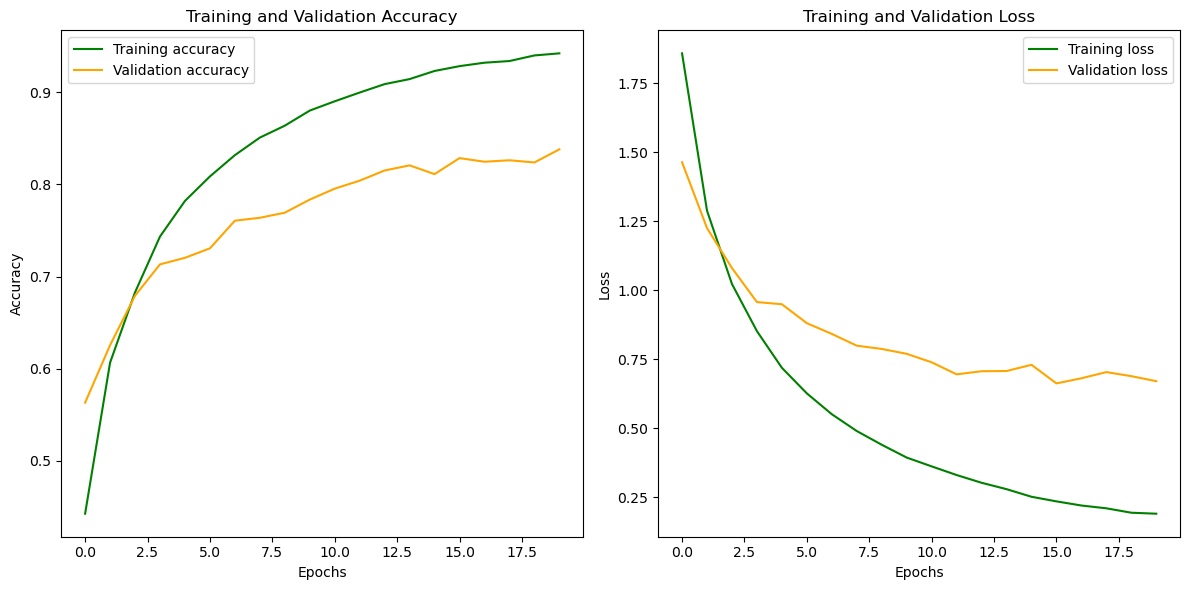

In [38]:
acc = history1.history['accuracy']
val_acc = history1.history['val_accuracy']
loss = history1.history['loss']
val_loss = history1.history['val_loss']

epochs = range(len(acc))

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# To plot side-by-side graph
# Plot accuracy
axs[0].plot(epochs, acc, 'g', label='Training accuracy')
axs[0].plot(epochs, val_acc, 'orange', label='Validation accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(epochs, loss, 'g', label='Training loss')
axs[1].plot(epochs, val_loss, 'orange', label='Validation loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
plt.show()

# # To plot top down graph
# plt.plot(epochs, acc, 'b')
# plt.plot(epochs, val_acc, 'g')
# plt.title('Training and Validation Accuracy CNN Augmented')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.show()

# plt.plot(epochs, loss, 'b')
# plt.plot(epochs, val_loss, 'r')
# plt.ylabel('loss')
# plt.xlabel('epoch')
# plt.legend(['train', 'val'], loc='upper left')
# plt.title('Training and Validation Loss CNN Augmented')
# plt.show()

# Re-Plotting Graph Without running fit or using saved json

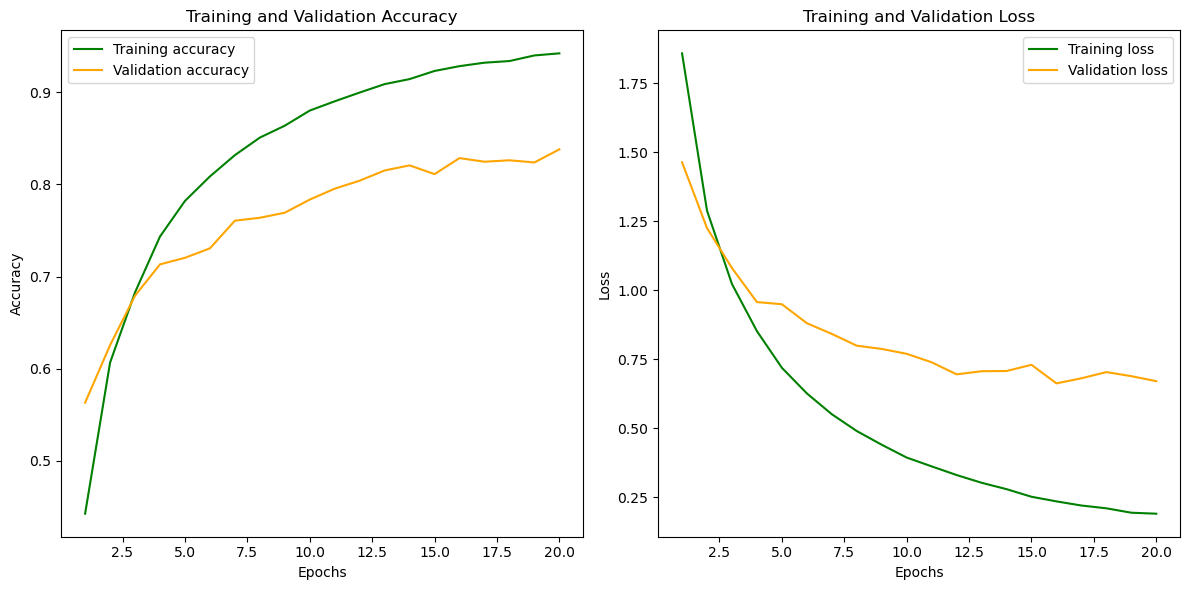

In [39]:
# Load the training history data from the JSON files
# history_file1 = '/content/saved_models/aug_cnn_history1.json'  # COLAB
history_file1 = '/Users/merchika/chikaData/TA/assets/new_json/NEW_UNDERSAMPLING_VGG16_model_2.json'  # Jupyter NB

def load_history_data(file_path):
    with open(file_path, 'r') as file:
        history_data = [json.loads(line) for line in file]
    return history_data

history_data1 = load_history_data(history_file1)
# print(history_data1)

# Extract metrics data from the first training session
acc_1 = [epoch['accuracy'] for epoch in history_data1]
val_acc_1 = [epoch['val_accuracy'] for epoch in history_data1]
loss_1 = [epoch['loss'] for epoch in history_data1]
val_loss_1 = [epoch['val_loss'] for epoch in history_data1]
epochs_1 = range(1, len(acc_1) + 1)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# To plot side-by-side graph
# Plot accuracy
axs[0].plot(epochs_1, acc_1, 'g', label='Training accuracy')
axs[0].plot(epochs_1, val_acc_1, 'orange', label='Validation accuracy')
axs[0].set_title('Training and Validation Accuracy')
axs[0].set_xlabel('Epochs')
axs[0].set_ylabel('Accuracy')
axs[0].legend()

# Plot loss
axs[1].plot(epochs_1, loss_1, 'g', label='Training loss')
axs[1].plot(epochs_1, val_loss_1, 'orange', label='Validation loss')
axs[1].set_title('Training and Validation Loss')
axs[1].set_xlabel('Epochs')
axs[1].set_ylabel('Loss')
axs[1].legend()

plt.tight_layout()
save_path = '/Users/merchika/chikaData/TA/assets/image/NEW_UNDERSAMPLING_VGG16_model_2.png'
plt.savefig(save_path)
plt.show()

# # To plot top down graph
# # Plot accuracy
# plt.plot(epochs_1, acc_1, 'b', label='Training accuracy')
# plt.plot(epochs_1, val_acc_1, 'g', label='Validation accuracy')
# plt.title('Training and Validation Accuracy')
# plt.xlabel('Epochs')
# plt.ylabel('Accuracy')
# plt.legend()
# plt.show()

# # Plot loss
# plt.plot(epochs_1, loss_1, 'b', label='Training loss')
# plt.plot(epochs_1, val_loss_1, 'r', label='Validation loss')
# plt.title('Training and Validation Loss')
# plt.xlabel('Epochs')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# Predictions

In [ ]:
x_validation_normalized.shape

In [ ]:
x_validation_normalized[0].shape

In [ ]:
224*224*3

In [ ]:
# Checking validation accuracy
np.set_printoptions(precision=3)
my_test = np.expand_dims(x_validation_normalized[0], axis=0)
my_test.shape

In [ ]:
model_1_0.predict(my_test)

In [ ]:
model_1_0.predict(my_test).sum()

In [ ]:
np.set_printoptions(precision=3)

In [ ]:
# all prob. for validation
model_1_0.predict(x_validation_normalized)

In [ ]:
# To check number of classes prediction
model_1_0.predict(x_validation_normalized).shape

In [ ]:
# prob. for validation for the class
# model.predict_classes(my_test) # predict_classes function has been removed from tf version 2.0

# axis=1, it means that the operation (in this case, argmax()) is applied along the columns of the array.
# axis=0 is applied along the rows of the array (axis=0 means that the function will find the index of the maximum value). 
class_predictions = model_1_0.predict(my_test)
predicted_classes = np.argmax(class_predictions, axis=1)
print(predicted_classes)

In [ ]:
# or simplified with below
# np.argmax(model.predict(my_test), axis=1)

In [ ]:
print(y_val.dtype)

In [ ]:
np.argmax(y_val[0])

In [ ]:
class_label = np.uint8(np.argmax(y_val[0]))
print(class_label)

In [ ]:
if y_val.dtype == np.float32:
    print("Labels are not one-hot encoded.")
    class_index = np.argmax(y_val[0])
    predicted_label = np.array([class_index], dtype=np.uint8)
    print(predicted_label) 

## Actual vs Predicted (Predict for the first 10 images)

In [ ]:
# Initialize lists to store actual and predicted labels
actual_labels = []
predicted_labels = []

# Iterate over the first 10 images in the validation set
for i in range(10):
    # Get the input image for prediction
    input_image = np.expand_dims(x_validation_normalized[i], axis=0)
    
    # Predict the class probabilities for the input image
    raw_predictions = model_1_0.predict(input_image)
    
    # Get the predicted class index
    predicted_class_index = np.argmax(raw_predictions, axis=1)[0]
    
    # Get the actual class label
    actual_class_index = np.argmax(y_val[i])
    
    # Append the actual and predicted labels to the lists
    actual_labels.append(actual_class_index)
    predicted_labels.append(predicted_class_index)

# Print the actual and predicted labels for the first 10 images
# print(f"Actual labels: {actual_labels} vs. Predicted labels: {predicted_labels}")
# print("Predicted labels:", predicted_labels)
for i in range(10):
    print(f"For Validation {i + 1}: Actual label: {actual_labels[i]} vs. Predicted label: {predicted_labels[i]}")

## To check details actual vs predicted

## Actual vs Predicted with x samples (Validation dataset - By Classes)

In [33]:
# Define the number of samples to use for each class
num_samples_per_class = 7

# Initialize a dictionary to store actual and predicted labels for each class
class_labels = {i: {'actual': [], 'predicted': []} for i in range(num_classes)}

# Iterate over each class
for class_index in range(num_classes):
    # Initialize a counter for the number of samples predicted for the current class
    num_samples_predicted = 0
    
    # Iterate over all samples
    for i in range(len(y_val)):
        # Check if the actual label matches the current class index
        if np.argmax(y_val[i]) == class_index:
            # Get the input image for prediction
            input_image = np.expand_dims(x_validation_normalized[i], axis=0)
            
            # Predict the class probabilities for the input image
            raw_predictions = model_1_0.predict(input_image, verbose=0)
            
            # Get the predicted class index
            predicted_class_index = np.argmax(raw_predictions, axis=1)[0]
            
            # Append the actual and predicted labels to the lists for the current class
            class_labels[class_index]['actual'].append(class_index)
            class_labels[class_index]['predicted'].append(predicted_class_index)
            
            # Increment the counter for the number of samples predicted for the current class
            num_samples_predicted += 1
            
            # Break out of the loop if the desired number of samples is reached for the current class
            if num_samples_predicted >= num_samples_per_class:
                break

# Print the actual and predicted labels for each class
for class_index in range(num_classes):
    actual_labels = class_labels[class_index]['actual']
    predicted_labels = class_labels[class_index]['predicted']
    class_name = LABEL_NAMES[class_index]  # Get the class name
    print(f"Class {class_name}:")
    for actual, predicted in zip(actual_labels, predicted_labels):
        print(f"Actual label: {actual} vs. Predicted label: {predicted}")

Class Aceh:
Actual label: 0 vs. Predicted label: 9
Actual label: 0 vs. Predicted label: 12
Actual label: 0 vs. Predicted label: 3
Actual label: 0 vs. Predicted label: 3
Actual label: 0 vs. Predicted label: 2
Actual label: 0 vs. Predicted label: 0
Actual label: 0 vs. Predicted label: 2
Class Bali:
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Class Betawi:
Actual label: 2 vs. Predicted label: 2
Actual label: 2 vs. Predicted label: 2
Actual label: 2 vs. Predicted label: 10
Actual label: 2 vs. Predicted label: 9
Actual label: 2 vs. Predicted label: 2
Actual label: 2 vs. Predicted label: 12
Actual label: 2 vs. Predicted label: 2
Class Ciamis:
Actual label: 3 vs. Predicted label: 3
Actual label: 3 vs. Predicted label: 13
Actual label: 3 vs. Predicted label: 17
Actual 

### Actual vs Predicted with x samples (Test Dataset- By classes)

In [34]:
# Define the number of samples to use for each class
num_samples_per_class = 7

# Initialize a dictionary to store actual and predicted labels for each class
class_labels = {i: {'actual': [], 'predicted': []} for i in range(num_classes)}

# Iterate over each class
for class_index in range(num_classes):
    # Initialize a counter for the number of samples predicted for the current class
    num_samples_predicted = 0
    
    # Iterate over all samples
    for i in range(len(y_test)):
        # Check if the actual label matches the current class index
        if np.argmax(y_test[i]) == class_index:
            # Get the input image for prediction
            input_image = np.expand_dims(x_test_normalized[i], axis=0)
            
            # Predict the class probabilities for the input image
            raw_predictions = model_1_0.predict(input_image, verbose=0)
            
            # Get the predicted class index
            predicted_class_index = np.argmax(raw_predictions, axis=1)[0]
            
            # Append the actual and predicted labels to the lists for the current class
            class_labels[class_index]['actual'].append(class_index)
            class_labels[class_index]['predicted'].append(predicted_class_index)
            
            # Increment the counter for the number of samples predicted for the current class
            num_samples_predicted += 1
            
            # Break out of the loop if the desired number of samples is reached for the current class
            if num_samples_predicted >= num_samples_per_class:
                break

# Print the actual and predicted labels for each class
for class_index in range(num_classes):
    actual_labels = class_labels[class_index]['actual']
    predicted_labels = class_labels[class_index]['predicted']
    class_name = LABEL_NAMES[class_index]  # Get the class name
    print(f"Class {class_name}:")
    for actual, predicted in zip(actual_labels, predicted_labels):
        print(f"Actual label: {actual} vs. Predicted label: {predicted}")

Class Aceh:
Actual label: 0 vs. Predicted label: 9
Actual label: 0 vs. Predicted label: 0
Actual label: 0 vs. Predicted label: 12
Actual label: 0 vs. Predicted label: 8
Actual label: 0 vs. Predicted label: 0
Actual label: 0 vs. Predicted label: 9
Actual label: 0 vs. Predicted label: 0
Class Bali:
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Actual label: 1 vs. Predicted label: 1
Class Betawi:
Actual label: 2 vs. Predicted label: 9
Actual label: 2 vs. Predicted label: 2
Actual label: 2 vs. Predicted label: 2
Actual label: 2 vs. Predicted label: 2
Actual label: 2 vs. Predicted label: 2
Actual label: 2 vs. Predicted label: 9
Actual label: 2 vs. Predicted label: 2
Class Ciamis:
Actual label: 3 vs. Predicted label: 18
Actual label: 3 vs. Predicted label: 13
Actual label: 3 vs. Predicted label: 11
Actual l

# Evaluation

## Training Dataset

In [40]:
model_1_0.metrics_names

['loss', 'accuracy']

In [41]:
test_loss, test_accuracy = model_1_0.evaluate(x_train_normalized, y_train)
print(f"Val loss : {test_loss:0.3} and the Val accuracy: {test_accuracy:0.2%}")

401/401 [==============================] - 4635s 12s/step - loss: 0.1004 - accuracy: 0.9753
Val loss : 0.1 and the Val accuracy: 97.53%


## Validation Dataset

In [42]:
model_1_0.metrics_names

['loss', 'accuracy']

In [43]:
test_loss, test_accuracy = model_1_0.evaluate(x_validation_normalized, y_val)
print(f"Val loss : {test_loss:0.3} and the Val accuracy: {test_accuracy:0.2%}")

40/40 [==============================] - 463s 12s/step - loss: 0.6703 - accuracy: 0.8381
Val loss : 0.67 and the Val accuracy: 83.81%


## Test Dataset

In [44]:
model_1_0.metrics_names

['loss', 'accuracy']

In [45]:
test_loss, test_accuracy = model_1_0.evaluate(x_test_normalized, y_test)
print(f"Test loss : {test_loss:0.3} and the test accuracy: {test_accuracy:0.2%}")

49/49 [==============================] - 561s 11s/step - loss: 0.7034 - accuracy: 0.8342
Test loss : 0.703 and the test accuracy: 83.42%


## Test Accuracies - By Classes ( Without Tables)

In [46]:
# Initialize dictionaries to store metrics for each class
class_metrics = {class_name: {'loss': 0.0, 'accuracy': 0.0} for class_name in LABEL_NAMES}

# Evaluate the model on the test data
test_metrics = model_1_0.evaluate(x_test_normalized, y_test, verbose=0)

# Extract the loss and accuracy values from the test metrics
test_loss = test_metrics[0]
test_accuracy = test_metrics[1]

# Print overall test metrics
print(f"Overall test loss : {test_loss:0.3} and the overall test accuracy: {test_accuracy:0.2%}")

# Calculate metrics for each class
for i, class_name in enumerate(LABEL_NAMES):
    # Get indices of test samples belonging to the current class
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    
    # Select test data and labels for the current class
    x_class_test = x_test_normalized[class_indices]
    y_class_test = y_test[class_indices]
    
    # Evaluate the model on the test data for the current class
    class_metrics[class_name]['loss'], class_metrics[class_name]['accuracy'] = model_1_0.evaluate(x_class_test, y_class_test, verbose=0)
    
    # Print metrics for the current class
    print(f"Class {class_name}: Test loss: {class_metrics[class_name]['loss']:.3f}, Test accuracy: {class_metrics[class_name]['accuracy']:.2%}")

Overall test loss : 0.703 and the overall test accuracy: 83.42%
Class Aceh: Test loss: 0.863, Test accuracy: 70.37%
Class Bali: Test loss: 0.409, Test accuracy: 90.65%
Class Betawi: Test loss: 2.490, Test accuracy: 51.85%
Class Ciamis: Test loss: 6.979, Test accuracy: 30.00%
Class Cirebon: Test loss: 0.186, Test accuracy: 93.81%
Class Garut: Test loss: 3.013, Test accuracy: 30.00%
Class Kalimantan_Dayak: Test loss: 2.042, Test accuracy: 66.67%
Class Kalimantan_Pontianak: Test loss: 0.087, Test accuracy: 94.69%
Class Kulon Progo_Geblek Renteng: Test loss: 0.424, Test accuracy: 87.12%
Class Madura: Test loss: 0.564, Test accuracy: 79.80%
Class Maluku_Pala Cengkeh: Test loss: 2.786, Test accuracy: 50.00%
Class Papua_Cendrawasih: Test loss: 0.479, Test accuracy: 87.86%
Class Pati: Test loss: 0.677, Test accuracy: 80.43%
Class Pekalongan: Test loss: 7.364, Test accuracy: 10.00%
Class Solo_Sidoluhur: Test loss: 2.404, Test accuracy: 70.00%
Class Solo_Sogan: Test loss: 5.017, Test accuracy: 5

## Test Accuracies - By Classes (With Table)

In [47]:
# Initialize dictionaries to store metrics for each class
class_metrics = {class_name: {'loss': 0.0, 'accuracy': 0.0} for class_name in LABEL_NAMES}

# Initialize lists to store overall test loss and accuracy for each class
overall_test_loss = []
overall_test_accuracy = []

# Calculate metrics for each class
for i, class_name in enumerate(LABEL_NAMES):
    # Get indices of test samples belonging to the current class
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    
    # Select test data and labels for the current class
    x_class_test = x_test_normalized[class_indices]
    y_class_test = y_test[class_indices]
    
    # Evaluate the model on the test data for the current class
    class_metrics[class_name]['loss'], class_metrics[class_name]['accuracy'] = model_1_0.evaluate(x_class_test, y_class_test, verbose=0)
    
    # Append metrics to overall lists
    overall_test_loss.append(class_metrics[class_name]['loss'])
    overall_test_accuracy.append(class_metrics[class_name]['accuracy'])

# Print table for metrics for each class
print("Test Metrics for Each Class:")
print("{:<30} {:<15} {:<15}".format("Class", "Test Loss", "Test Accuracy"))
print("-" * 60)
for class_name in LABEL_NAMES:
    print("{:<30} {:<15.3f} {:<15.2%}".format(class_name, class_metrics[class_name]['loss'], class_metrics[class_name]['accuracy']))

# Print overall test metrics
print("\nOverall Test Metrics:")
print(f"Overall test loss : {np.mean(overall_test_loss):0.3} and the overall test accuracy: {np.mean(overall_test_accuracy):0.2%}")

Test Metrics for Each Class:
Class                          Test Loss       Test Accuracy  
------------------------------------------------------------
Aceh                           0.863           70.37%         
Bali                           0.409           90.65%         
Betawi                         2.490           51.85%         
Ciamis                         6.979           30.00%         
Cirebon                        0.186           93.81%         
Garut                          3.013           30.00%         
Kalimantan_Dayak               2.042           66.67%         
Kalimantan_Pontianak           0.087           94.69%         
Kulon Progo_Geblek Renteng     0.424           87.12%         
Madura                         0.564           79.80%         
Maluku_Pala Cengkeh            2.786           50.00%         
Papua_Cendrawasih              0.479           87.86%         
Pati                           0.677           80.43%         
Pekalongan                  

## Test Accuracies - By Classes (With Table - Grouped by Test Acc.)

In [48]:
# Initialize dictionaries to store metrics for each class
class_metrics = {class_name: {'loss': 0.0, 'accuracy': 0.0} for class_name in LABEL_NAMES}

# Initialize lists to store overall test loss and accuracy for each class
overall_test_loss = []
overall_test_accuracy = []

# Calculate metrics for each class
for i, class_name in enumerate(LABEL_NAMES):
    # Get indices of test samples belonging to the current class
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    
    # Select test data and labels for the current class
    x_class_test = x_test_normalized[class_indices]
    y_class_test = y_test[class_indices]
    
    # Evaluate the model on the test data for the current class  
    class_metrics[class_name]['loss'], class_metrics[class_name]['accuracy'] = model_1_0.evaluate(x_class_test, y_class_test, verbose=0)
    
    # Append metrics to overall lists
    overall_test_loss.append(class_metrics[class_name]['loss'])
    overall_test_accuracy.append(class_metrics[class_name]['accuracy'])

# Sort class metrics by test accuracy
sorted_class_metrics = sorted(class_metrics.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print table for metrics for each class sorted by test accuracy
print("Test Metrics for Each Class (Sorted by Test Accuracy):")
print("{:<30} {:<15} {:<15}".format("Class", "Test Loss", "Test Accuracy"))
print("-" * 60)
for class_name, metrics in sorted_class_metrics:
    print("{:<30} {:<15.3f} {:<15.2%}".format(class_name, metrics['loss'], metrics['accuracy']))

# Print overall test metrics
print("\nOverall Test Metrics:")
print(f"Overall test loss: {np.mean(overall_test_loss):.3f} and the overall test accuracy: {np.mean(overall_test_accuracy):.2%}")

Test Metrics for Each Class (Sorted by Test Accuracy):
Class                          Test Loss       Test Accuracy  
------------------------------------------------------------
Kalimantan_Pontianak           0.087           94.69%         
Yogyakarta_Sekar Jagad         0.171           93.94%         
Cirebon                        0.186           93.81%         
Yogyakarta_Tambal              0.271           93.62%         
Bali                           0.409           90.65%         
Papua_Cendrawasih              0.479           87.86%         
Kulon Progo_Geblek Renteng     0.424           87.12%         
Pati                           0.677           80.43%         
Madura                         0.564           79.80%         
Yogyakarta_Kawung              1.448           76.92%         
Aceh                           0.863           70.37%         
Solo_Sidoluhur                 2.404           70.00%         
Kalimantan_Dayak               2.042           66.67%         
Be

# Confusion Matrix

In [49]:
predictions = model_1_0.predict(x_test_normalized)
y_test_labels = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true=y_test_labels, y_pred=predictions.argmax(axis=1))

49/49 [==============================] - 563s 11s/step


In [50]:
conf_matrix.shape

(20, 20)

In [51]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

In [52]:
1280/32

40.0

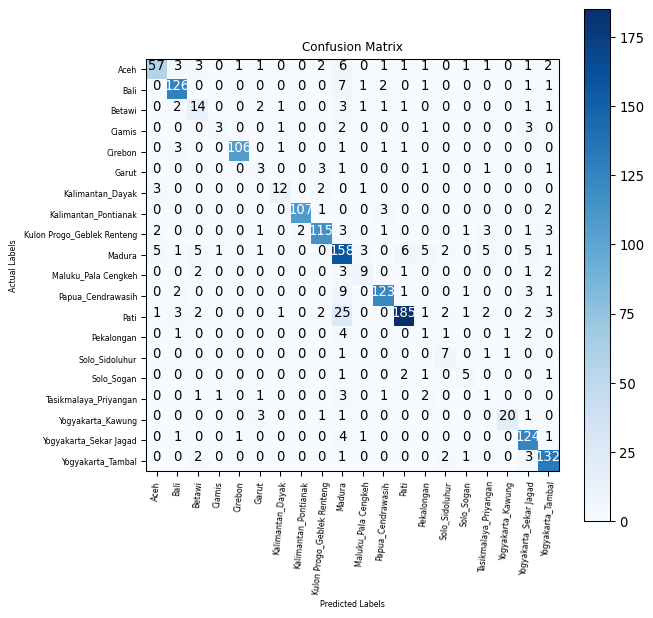

In [53]:
plt.figure(figsize=(7,7), dpi=95)
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

plt.title('Confusion Matrix', fontsize=9)
plt.ylabel('Actual Labels', fontsize=6)
plt.xlabel('Predicted Labels', fontsize=6)


tick_marks = np.arange(test_num_classes)
plt.yticks(tick_marks, LABEL_NAMES, fontsize=6)
plt.xticks(tick_marks, LABEL_NAMES, fontsize=6, rotation=85)

plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
            color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')


plt.show()

## True Positive, Recall, Precision, F1-Score

In [54]:
np.diag(conf_matrix)

array([ 57, 126,  14,   3, 106,   3,  12, 107, 115, 158,   9, 123, 185,
         1,   7,   5,   1,  20, 124, 132])

In [55]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.7037037 , 0.90647482, 0.51851852, 0.3       , 0.9380531 ,
       0.3       , 0.66666667, 0.94690265, 0.87121212, 0.7979798 ,
       0.5       , 0.87857143, 0.80434783, 0.1       , 0.7       ,
       0.5       , 0.1       , 0.76923077, 0.93939394, 0.93617021])

In [56]:
# axis=0 means the sum will be calculated along the vertical axis (column-wise)
# axis=1 means the sum is calculated along the horizontal axis (row-wise)
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision = np.nan_to_num(precision, nan=0)  # assuming there is a NaN then replace with 0
precision

# Use this if there is no NaN
# precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
# precision

array([0.83823529, 0.88732394, 0.48275862, 0.6       , 0.98148148,
       0.25      , 0.75      , 0.98165138, 0.91269841, 0.67811159,
       0.5625    , 0.92481203, 0.93434343, 0.07142857, 0.5       ,
       0.5       , 0.07142857, 0.90909091, 0.83783784, 0.87417219])

In [57]:
avg_recall = np.mean(recall)
print(f'Model recall score is {avg_recall:.2%}')

Model recall score is 65.89%


In [58]:
avg_precision = np.mean(precision)
print(f'Model precision score is {avg_precision:.2%}')

f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
print(f'Model f score is {f1_score:.2%}')

# f1_score_numpy = np.mean(2 * class_precision * class_recall / (class_precision + class_recall))
# print(f'f1_score_numpy: {f1_score_numpy}')

Model precision score is 67.74%
Model f score is 66.80%


In [59]:
# Calculate precision, recall, and F1 score for each class

metrics_per_class = []
for i in range(len(LABEL_NAMES)):
    recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
    precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i])
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    metrics_per_class.append({'Class': LABEL_NAMES[i], 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score})

# Sort metrics by F1 Score
metrics_per_class_sorted = sorted(metrics_per_class, key=lambda x: x['F1 Score'], reverse=True)

# Print metrics for each class
print("{:<30} {:<15} {:<15} {:<15}".format('Class', 'Recall', 'Precision', 'F1 Score'))
print("-" * 75)
for metric in metrics_per_class_sorted:
    print("{:<30} {:<15.2%} {:<15.2%} {:<15.2%}".format(metric['Class'], metric['Recall'], metric['Precision'], metric['F1 Score']))

# Calculate overall F1 Score using the standard equation
overall_precision = np.mean([metric['Precision'] for metric in metrics_per_class])
overall_recall = np.mean([metric['Recall'] for metric in metrics_per_class])
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) != 0 else 0

print("\nOverall Metrics:")
print(f'Recall: {avg_recall:.2%}')
print(f'Precision: {avg_precision:.2%}')
print(f'Overall F1 Score: {overall_f1_score:.2%}')

Class                          Recall          Precision       F1 Score       
---------------------------------------------------------------------------
Kalimantan_Pontianak           94.69%          98.17%          96.40%         
Cirebon                        93.81%          98.15%          95.93%         
Yogyakarta_Tambal              93.62%          87.42%          90.41%         
Papua_Cendrawasih              87.86%          92.48%          90.11%         
Bali                           90.65%          88.73%          89.68%         
Kulon Progo_Geblek Renteng     87.12%          91.27%          89.15%         
Yogyakarta_Sekar Jagad         93.94%          83.78%          88.57%         
Pati                           80.43%          93.43%          86.45%         
Yogyakarta_Kawung              76.92%          90.91%          83.33%         
Aceh                           70.37%          83.82%          76.51%         
Madura                         79.80%          67.81%  

# =========================

# To Run Predictions and Confusion Matrix Using Load Model

## Predictions

In [60]:
# def save_results_to_csv(file_path, model_name, phase, loss, accuracy):
#     # Check if file exists
#     try:
#         with open(file_path, 'x', newline='') as csvfile:
#             writer = csv.writer(csvfile)
#             writer.writerow(['Model', 'Phase', 'Loss', 'Accuracy'])
#     except FileExistsError:
#         pass

#     # Append the results
#     with open(file_path, 'a', newline='') as csvfile:
#         writer = csv.writer(csvfile)
#         writer.writerow([model_name, phase, f"{loss:.4f}", f"{accuracy:.2%}"])

# # Load model
# model_name = 'Undersampling_VGG16'
next1_model = load_model('/Users/merchika/chikaData/TA/assets/new_models/NEW_UNDERSAMPLING_VGG16_model_2.h5')

# # Define file path
# file_path = '/Users/merchika/chikaData/TA/assets/csv/undersampling/vgg16_accuracy_loss_result.csv'

#### Train Dataset Phase

In [61]:
train_loss, train_accuracy = next1_model.evaluate(x_train_normalized, y_train)
print(f"Train loss : {train_loss:0.3} and the Train accuracy: {train_accuracy:0.2%}")

# save_results_to_csv(file_path, model_name, 'Train', train_loss, train_accuracy)

401/401 [==============================] - 4737s 12s/step - loss: 0.1004 - accuracy: 0.9753
Train loss : 0.1 and the Train accuracy: 97.53%


#### Validation Dataset Phase

In [62]:
val_loss, val_accuracy = next1_model.evaluate(x_validation_normalized, y_val)
print(f"Val loss : {val_loss:0.3} and the Val accuracy: {val_accuracy:0.2%}")

# save_results_to_csv(file_path, model_name, 'Validation', val_loss, val_accuracy)

40/40 [==============================] - 465s 12s/step - loss: 0.6703 - accuracy: 0.8381
Val loss : 0.67 and the Val accuracy: 83.81%


#### Test Dataset Phase

In [63]:
test_loss, test_accuracy = next1_model.evaluate(x_test_normalized, y_test)
print(f"Test loss : {test_loss:0.3} and the Test accuracy: {test_accuracy:0.2%}")

# save_results_to_csv(file_path, model_name, 'Test', test_loss, test_accuracy)

49/49 [==============================] - 578s 12s/step - loss: 0.7034 - accuracy: 0.8342
Test loss : 0.703 and the Test accuracy: 83.42%


***

In [25]:
# next4_model = load_model('/content/saved_models/hist4_flat_raw_model.h5')
next1_model = load_model('/Users/merchika/chikaData/TA/assets/new_models/NEW_UNDERSAMPLING_VGG16_model_2.h5')

In [26]:
next1_model.metrics_names

['loss', 'accuracy']

In [27]:
train_loss, train_accuracy = next1_model.evaluate(x_train_normalized, y_train)
print(f"train loss : {train_loss:0.3} and the train accuracy: {train_accuracy:0.2%}")

396/396 [==============================] - 7230s 18s/step - loss: 0.1903 - accuracy: 0.9473
train loss : 0.19 and the train accuracy: 94.73%


## Validation Dataset

In [28]:
next1_model.metrics_names

['loss', 'accuracy']

In [29]:
val_loss, val_accuracy = next1_model.evaluate(x_validation_normalized, y_val)
print(f"Val loss : {val_loss:0.3} and the Val accuracy: {val_accuracy:0.2%}")

40/40 [==============================] - 483s 12s/step - loss: 0.6601 - accuracy: 0.8318
Val loss : 0.66 and the Val accuracy: 83.18%


## Test Dataset

In [30]:
next1_model.metrics_names

['loss', 'accuracy']

In [31]:
test_loss, test_accuracy = next1_model.evaluate(x_test_normalized, y_test)
print(f"Test loss : {test_loss:0.3} and the test accuracy: {test_accuracy:0.2%}")

49/49 [==============================] - 595s 12s/step - loss: 0.6873 - accuracy: 0.8284
Test loss : 0.687 and the test accuracy: 82.84%


In [32]:
np.set_printoptions(precision=3)
test_loss, test_accuracy = next1_model.evaluate(x_test_normalized, y_test)
print(f"Test loss : {test_loss:0.3} and the test accuracy: {test_accuracy:0.3%}")

49/49 [==============================] - 608s 12s/step - loss: 0.6873 - accuracy: 0.8284
Test loss : 0.687 and the test accuracy: 82.844%


In [33]:
print(x_validation_normalized.shape)
print(x_test_normalized.shape)
print(1020/32)
print(1280/32)

(1266, 224, 224, 3)
(1568, 224, 224, 3)
31.875
40.0


In [34]:
# Initialize lists to store actual and predicted labels
actual_labels = []
predicted_labels = []

# Iterate over the first 10 images in the validation set
for i in range(10):
    # Get the input image for prediction
    input_image = np.expand_dims(x_validation_normalized[i], axis=0)
    
    # Predict the class probabilities for the input image
    raw_predictions = next1_model.predict(input_image)
    
    # Get the predicted class index
    predicted_class_index = np.argmax(raw_predictions, axis=1)[0]
    
    # Get the actual class label
    actual_class_index = np.argmax(y_val[i])
    
    # Append the actual and predicted labels to the lists
    actual_labels.append(actual_class_index)
    predicted_labels.append(predicted_class_index)

# Print the actual and predicted labels for the first 10 images
# print(f"Actual labels: {actual_labels} vs. Predicted labels: {predicted_labels}")
# print("Predicted labels:", predicted_labels)
for i in range(10):
    print(f"For Validation {i + 1}: Actual label: {actual_labels[i]} vs. Predicted label: {predicted_labels[i]}")

1/1 [==============================] - 0s 367ms/step
For Validation 1: Actual label: 7 vs. Predicted label: 7
For Validation 2: Actual label: 9 vs. Predicted label: 9
For Validation 3: Actual label: 18 vs. Predicted label: 1
For Validation 4: Actual label: 9 vs. Predicted label: 9
For Validation 5: Actual label: 5 vs. Predicted label: 19
For Validation 6: Actual label: 9 vs. Predicted label: 9
For Validation 7: Actual label: 0 vs. Predicted label: 11
For Validation 8: Actual label: 9 vs. Predicted label: 9
For Validation 9: Actual label: 12 vs. Predicted label: 12
For Validation 10: Actual label: 0 vs. Predicted label: 0


***

In [64]:
# Save class metrics to CSV
file_path = '/Users/merchika/chikaData/TA/assets/csv/new/new_vgg16_undersampling_classes_test_accy_2.csv'  # Change to path
dataset_type = 'Undersampling Dataset'  # Update with used dataset type
model_architecture = 'VGG16'  # Update with used model architecture

def save_class_metrics_to_csv(file_path, dataset_type, model_architecture, sorted_class_metrics):
    # Check if file exists
    try:
        with open(file_path, 'x', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Dataset_Type', 'Model_Architecture', 'Class', 'Test_Loss', 'Test_Accuracy'])
    except FileExistsError:
        pass

# Append sorted class metrics to the CSV file so that the same like print output
with open(file_path, 'a', newline='') as csvfile:
    writer = csv.writer(csvfile)
    for class_name, metrics in sorted_class_metrics:
        writer.writerow([
            dataset_type,
            model_architecture,
            class_name,
            f"{metrics['loss']:.4f}",
            f"{metrics['accuracy']:.2%}"
        ])

In [65]:
# Initialize dictionaries to store metrics for each class
class_metrics = {class_name: {'loss': 0.0, 'accuracy': 0.0} for class_name in LABEL_NAMES}

# Initialize lists to store overall test loss and accuracy for each class
overall_test_loss = []
overall_test_accuracy = []

# Calculate metrics for each class
for i, class_name in enumerate(LABEL_NAMES):
    # Get indices of test samples belonging to the current class
    class_indices = np.where(np.argmax(y_test, axis=1) == i)[0]
    
    # Select test data and labels for the current class
    x_class_test = x_test_normalized[class_indices]
    y_class_test = y_test[class_indices]
    
    # Evaluate the model on the test data for the current class  
    class_metrics[class_name]['loss'], class_metrics[class_name]['accuracy'] = next1_model.evaluate(x_class_test, y_class_test, verbose=0)
    
    # Append metrics to overall lists
    overall_test_loss.append(class_metrics[class_name]['loss'])
    overall_test_accuracy.append(class_metrics[class_name]['accuracy'])

# Sort class metrics by test accuracy
sorted_class_metrics = sorted(class_metrics.items(), key=lambda x: x[1]['accuracy'], reverse=True)

# Print table for metrics for each class sorted by test accuracy
print("Test Metrics for Each Class (Sorted by Test Accuracy):")
print("{:<30} {:<15} {:<15}".format("Class", "Test Loss", "Test Accuracy"))
print("-" * 60)
for class_name, metrics in sorted_class_metrics:
    print("{:<30} {:<15.3f} {:<15.2%}".format(class_name, metrics['loss'], metrics['accuracy']))

# Print overall test metrics
print("\nOverall Test Metrics:")
print(f"Overall test loss: {np.mean(overall_test_loss):.3f} and the overall test accuracy: {np.mean(overall_test_accuracy):.2%}")

save_class_metrics_to_csv(file_path, dataset_type, model_architecture, sorted_class_metrics)

Test Metrics for Each Class (Sorted by Test Accuracy):
Class                          Test Loss       Test Accuracy  
------------------------------------------------------------
Kalimantan_Pontianak           0.087           94.69%         
Yogyakarta_Sekar Jagad         0.171           93.94%         
Cirebon                        0.186           93.81%         
Yogyakarta_Tambal              0.271           93.62%         
Bali                           0.409           90.65%         
Papua_Cendrawasih              0.479           87.86%         
Kulon Progo_Geblek Renteng     0.424           87.12%         
Pati                           0.677           80.43%         
Madura                         0.564           79.80%         
Yogyakarta_Kawung              1.448           76.92%         
Aceh                           0.863           70.37%         
Solo_Sidoluhur                 2.404           70.00%         
Kalimantan_Dayak               2.042           66.67%         
Be

# Confusion Matrix

In [66]:
predictions = next1_model.predict(x_test_normalized)
y_test_labels = np.argmax(y_test, axis=1)
conf_matrix = confusion_matrix(y_true=y_test_labels, y_pred=predictions.argmax(axis=1))

49/49 [==============================] - 574s 12s/step


In [67]:
conf_matrix.shape

(20, 20)

In [68]:
nr_rows = conf_matrix.shape[0]
nr_cols = conf_matrix.shape[1]

## Test Accuracies - By Classes (With Table - Grouped by Test Acc.) - Save to CSV

In [71]:
# Initialize dictionaries to store metrics for each class
metrics_per_class = []
for i in range(len(LABEL_NAMES)):
    recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
    precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i])
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    metrics_per_class.append({'Class': LABEL_NAMES[i], 'Recall': recall, 'Precision': precision, 'F1 Score': f1_score})

# Sort metrics by F1 Score
metrics_per_class_sorted = sorted(metrics_per_class, key=lambda x: x['F1 Score'], reverse=True)

# Print metrics for each class
print("{:<30} {:<15} {:<15} {:<15}".format('Class', 'Recall', 'Precision', 'F1 Score'))
print("-" * 75)
for metric in metrics_per_class_sorted:
    print("{:<30} {:<15.2%} {:<15.2%} {:<15.2%}".format(metric['Class'], metric['Recall'], metric['Precision'], metric['F1 Score']))

# Calculate overall metrics
overall_precision = np.mean([metric['Precision'] for metric in metrics_per_class])
overall_recall = np.mean([metric['Recall'] for metric in metrics_per_class])
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) != 0 else 0

overall_metrics = {
    'Recall': overall_recall,
    'Precision': overall_precision,
    'F1 Score': overall_f1_score
}

print("\nOverall Metrics:")
print(f"Recall: {overall_recall:.2%}")
print(f"Precision: {overall_precision:.2%}")
print(f"Overall F1 Score: {overall_f1_score:.2%}")
# Save sorted class metrics and overall metrics to CSV

# Calling the function
save_metrics_to_csv(file_path, dataset_type, model_architecture, metrics_per_class_sorted, overall_metrics)

Class                          Recall          Precision       F1 Score       
---------------------------------------------------------------------------
Kalimantan_Pontianak           94.69%          98.17%          96.40%         
Cirebon                        93.81%          98.15%          95.93%         
Yogyakarta_Tambal              93.62%          87.42%          90.41%         
Papua_Cendrawasih              87.86%          92.48%          90.11%         
Bali                           90.65%          88.73%          89.68%         
Kulon Progo_Geblek Renteng     87.12%          91.27%          89.15%         
Yogyakarta_Sekar Jagad         93.94%          83.78%          88.57%         
Pati                           80.43%          93.43%          86.45%         
Yogyakarta_Kawung              76.92%          90.91%          83.33%         
Aceh                           70.37%          83.82%          76.51%         
Madura                         79.80%          67.81%  

In [72]:
# Save class metrics to CSV
file_path = '/Users/merchika/chikaData/TA/assets/csv/new/new_vgg16_undersampling_classes_test_accy_2.csv'  # Change to path
dataset_type = 'Undersampling Dataset'  # Update with used dataset type
model_architecture = 'VGG16'  # Update with used model architecture

def save_metrics_to_csv(file_path, dataset_type, model_architecture, sorted_metrics, overall_metrics):
    # Check if file exists
    try:
        with open(file_path, 'x', newline='') as csvfile:
            writer = csv.writer(csvfile)
            writer.writerow(['Dataset_Type', 'Model_Architecture', 'Class', 'Recall', 'Precision', 'F1 Score'])
    except FileExistsError:
        pass

    # Append sorted class metrics to the CSV file
    with open(file_path, 'a', newline='') as csvfile:
        writer = csv.writer(csvfile)
        for metric in sorted_metrics:
            writer.writerow([
                dataset_type,
                model_architecture,
                metric['Class'],
                f"{metric['Recall']:.2%}",
                f"{metric['Precision']:.2%}",
                f"{metric['F1 Score']:.2%}"
            ])

        # Add a blank row before the overall metrics
        writer.writerow([])

        # Append overall metrics
        writer.writerow([
            dataset_type,
            model_architecture,
            'Overall',
            f"{overall_metrics['Recall']:.2%}",
            f"{overall_metrics['Precision']:.2%}",
            f"{overall_metrics['F1 Score']:.2%}"
        ])

In [73]:
1280/32

40.0

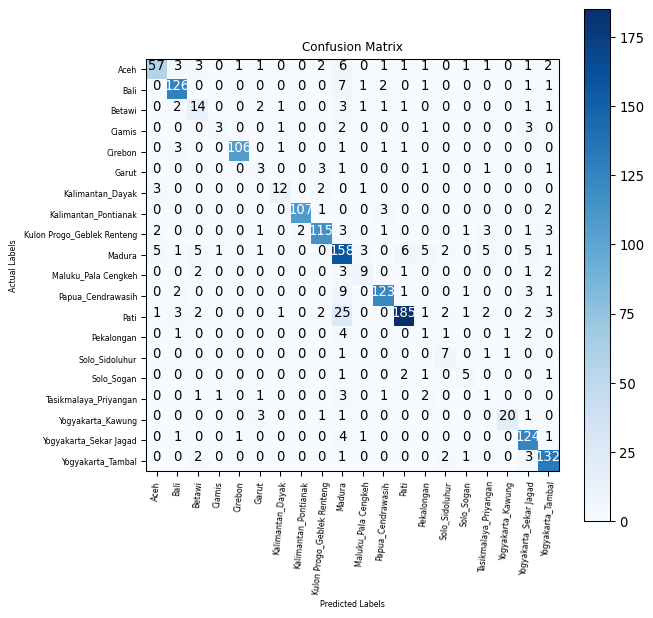

In [74]:
plt.figure(figsize=(7,7), dpi=95)
plt.imshow(conf_matrix, cmap=plt.cm.Blues)

plt.title('Confusion Matrix', fontsize=9)
plt.ylabel('Actual Labels', fontsize=6)
plt.xlabel('Predicted Labels', fontsize=6)

tick_marks = np.arange(test_num_classes)
plt.yticks(tick_marks, LABEL_NAMES, fontsize=6)
plt.xticks(tick_marks, LABEL_NAMES, fontsize=6, rotation=85)

plt.colorbar()

for i, j in itertools.product(range(nr_rows), range(nr_cols)):
    plt.text(j, i, conf_matrix[i, j], horizontalalignment='center',
            color='white' if conf_matrix[i, j] > conf_matrix.max()/2 else 'black')

save_path = '/Users/merchika/chikaData/TA/assets/image/CONFUMATR_NEW_UNDERSAMPLING_VGG16_model_2.png'
plt.savefig(save_path)

plt.show()

## True Positive, Recall, Precision, F1-Score

In [75]:
np.diag(conf_matrix)

array([ 57, 126,  14,   3, 106,   3,  12, 107, 115, 158,   9, 123, 185,
         1,   7,   5,   1,  20, 124, 132])

In [76]:
recall = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
recall

array([0.7037037 , 0.90647482, 0.51851852, 0.3       , 0.9380531 ,
       0.3       , 0.66666667, 0.94690265, 0.87121212, 0.7979798 ,
       0.5       , 0.87857143, 0.80434783, 0.1       , 0.7       ,
       0.5       , 0.1       , 0.76923077, 0.93939394, 0.93617021])

In [77]:
# axis=0 means the sum will be calculated along the vertical axis (column-wise)
# axis=1 means the sum is calculated along the horizontal axis (row-wise)
precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
precision = np.nan_to_num(precision, nan=0)  # assuming there is a NaN then replace with 0
precision

# Use this if there is no NaN
# precision = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
# precision

array([0.83823529, 0.88732394, 0.48275862, 0.6       , 0.98148148,
       0.25      , 0.75      , 0.98165138, 0.91269841, 0.67811159,
       0.5625    , 0.92481203, 0.93434343, 0.07142857, 0.5       ,
       0.5       , 0.07142857, 0.90909091, 0.83783784, 0.87417219])

In [78]:
avg_recall = np.mean(recall)
print(f'Model recall score is {avg_recall:.2%}')

Model recall score is 65.89%


In [79]:
avg_precision = np.mean(precision)
print(f'Model precision score is {avg_precision:.2%}')

f1_score = 2 * (avg_precision * avg_recall) / (avg_precision + avg_recall)
print(f'Model f score is {f1_score:.2%}')

# f1_score_numpy = np.mean(2 * class_precision * class_recall / (class_precision + class_recall))
# print(f'f1_score_numpy: {f1_score_numpy}')

Model precision score is 67.74%
Model f score is 66.80%


#### USING SKLEARN CLASSIFICATION REPORT

In [80]:
import re

# Define a function to convert float to percentage
def convert_to_percentage(value):
    # return f"{value * 100:.2f}%"
    return f"{value}"
# Generate the classification report
report = classification_report(y_test_labels, predictions.argmax(axis=1), target_names=LABEL_NAMES, zero_division=0, digits=4)

# Separate the report into class metrics and summary metrics
lines = report.split('\n')
class_metrics = []
summary_metrics = []
headings = None

# Iterate through each line in the report
for line in lines:
    # Check for headings
    if 'precision' in line and 'recall' in line and 'f1-score' in line and 'support' in line:
        headings = line
    
    # Check for summary metrics
    elif any(summary_key in line for summary_key in ['accuracy', 'macro avg', 'weighted avg']):
        summary_metrics.append(line)
    else:
        # Separate class metric lines
        if line.strip():
            match = re.search(r"^([\w\s]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)", line)
            if match:
                label = match.group(1)
                precision = float(match.group(2))
                recall = float(match.group(3))
                f1_score = float(match.group(4))
                support = int(match.group(5))
                class_metrics.append((label, precision, recall, f1_score, support))
# Sort class metrics by F1-score in descending order
class_metrics.sort(key=lambda x: x[3], reverse=True)

# Combine sorted class metrics and summary metrics
final_report = []
if headings:
    final_report.append(headings)

# Add sorted class metrics with percentages to the report
for label, precision, recall, f1_score, support in class_metrics:
    precision_percentage = convert_to_percentage(precision)
    recall_percentage = convert_to_percentage(recall)
    f1_score_percentage = convert_to_percentage(f1_score)
    final_report.append(f"{label:<30} {precision_percentage:<10} {recall_percentage:<10} {f1_score_percentage:<10} {support}")

# Add an extra blank line before the summary metrics
final_report.append('')

# Add summary metrics at the bottom
final_report.extend(summary_metrics)

# Join the report lines and print
print('\n'.join(final_report))

                            precision    recall  f1-score   support
      Kalimantan_Pontianak     0.9817     0.9469     0.964      113
                   Cirebon     0.9815     0.9381     0.9593     113
         Yogyakarta_Tambal     0.8742     0.9362     0.9041     141
         Papua_Cendrawasih     0.9248     0.8786     0.9011     140
                      Bali     0.8873     0.9065     0.8968     139
Kulon Progo_Geblek Renteng     0.9127     0.8712     0.8915     132
    Yogyakarta_Sekar Jagad     0.8378     0.9394     0.8857     132
                      Pati     0.9343     0.8043     0.8645     230
         Yogyakarta_Kawung     0.9091     0.7692     0.8333     26
                      Aceh     0.8382     0.7037     0.7651     81
                    Madura     0.6781     0.798      0.7332     198
          Kalimantan_Dayak     0.75       0.6667     0.7059     18
            Solo_Sidoluhur     0.5        0.7        0.5833     10
       Maluku_Pala Cengkeh     0.5625     0.5       

#### USING MANUAL

In [81]:
# ============ then compared with the manual one that we had before Precision, Recall, F1, and modified a bit with Support  ========

# Calculate metrics per class and add support
metrics_per_class = []
for i in range(len(LABEL_NAMES)):
    recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
    precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i])
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Calculate support for each class, support is the number of images per class
    support = np.sum(conf_matrix[i, :])  # Support is the sum of the row [i] in the confusion matrix
    
    # Add metrics and support to the list
    metrics_per_class.append({
        'Class': LABEL_NAMES[i],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Support': support
    })

# Sort metrics by F1 Score
metrics_per_class_sorted = sorted(metrics_per_class, key=lambda x: x['F1 Score'], reverse=True)
# To print metrics for each class including support
print("{:<30} {:<12} {:<12} {:<12} {:<12}".format('Class', 'Precision', 'Recall', 'F1 Score', 'Support'))
print("-" * 78)
for metric in metrics_per_class_sorted:
    print("{:<30} {:<12.2%} {:<12.2%} {:<12.2%} {:<12}".format(
        metric['Class'], metric['Precision'], metric['Recall'], metric['F1 Score'], metric['Support']))

# Calculate overall F1 Score using the standard equation
overall_precision = np.mean([metric['Precision'] for metric in metrics_per_class])
overall_recall = np.mean([metric['Recall'] for metric in metrics_per_class])
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) != 0 else 0

# =================
# Adding Accuracy, Macro avg and Weighted avg 
# Total number of observations (number of classes x no. images / perclass)
total_observations = np.sum(conf_matrix)

# Calculate accuracy
accuracy = np.sum(np.diag(conf_matrix)) / total_observations

# Calculate macro average
macro_avg_precision = np.mean([metric['Precision'] for metric in metrics_per_class])
macro_avg_recall = np.mean([metric['Recall'] for metric in metrics_per_class])
macro_avg_f1 = np.mean([metric['F1 Score'] for metric in metrics_per_class])

# Calculate weighted average
weighted_avg_precision = 0
weighted_avg_recall = 0
weighted_avg_f1 = 0


for i, metric in enumerate(metrics_per_class):
    support = np.sum(conf_matrix[i, :])
    weight = support / total_observations
    
    weighted_avg_precision += metric['Precision'] * weight
    weighted_avg_recall += metric['Recall'] * weight
    weighted_avg_f1 += metric['F1 Score'] * weight

print("\n")
# print(f"{'':<24} {'precision':>12} {'recall':>12} {'f1-score':>12}")
# print(f"{'accuracy':<45}{accuracy:>12.2%}")
print(f"{'accuracy':<25}{'':>26.4}{accuracy:>12.2%} {total_observations:>10}")
print(f"{'macro avg':<25}{macro_avg_precision:>12.2%} {macro_avg_recall:>12.2%} {macro_avg_f1:>12.2%} {total_observations:>10}")
print(f"{'weighted avg':<25}{weighted_avg_precision:>12.2%} {weighted_avg_recall:>12.2%} {weighted_avg_f1:>12.2%} {total_observations:>10}")

# =================

print("\nOverall Metrics:")
print(f"Recall: {overall_recall:.2%}")
print(f"Precision: {overall_precision:.2%}")
print(f"Overall F1 Score: {overall_f1_score:.2%}")

Class                          Precision    Recall       F1 Score     Support     
------------------------------------------------------------------------------
Kalimantan_Pontianak           98.17%       94.69%       96.40%       113         
Cirebon                        98.15%       93.81%       95.93%       113         
Yogyakarta_Tambal              87.42%       93.62%       90.41%       141         
Papua_Cendrawasih              92.48%       87.86%       90.11%       140         
Bali                           88.73%       90.65%       89.68%       139         
Kulon Progo_Geblek Renteng     91.27%       87.12%       89.15%       132         
Yogyakarta_Sekar Jagad         83.78%       93.94%       88.57%       132         
Pati                           93.43%       80.43%       86.45%       230         
Yogyakarta_Kawung              90.91%       76.92%       83.33%       26          
Aceh                           83.82%       70.37%       76.51%       81          
Madura  

#### COMPARISON MANUAL VS CLASSIFICATION

In [82]:
# Calculate metrics per class and add support
metrics_per_class = []
for i in range(len(LABEL_NAMES)):
    recall = conf_matrix[i, i] / np.sum(conf_matrix[i, :])
    precision = conf_matrix[i, i] / np.sum(conf_matrix[:, i])
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0
    
    # Calculate support for each class
    support = np.sum(conf_matrix[i, :])  # Support is the sum of the row i in the confusion matrix
    
    # Add metrics and support to the list
    metrics_per_class.append({
        'Class': LABEL_NAMES[i],
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'Support': support
    })

# Sort metrics by F1 Score
metrics_per_class_sorted = sorted(metrics_per_class, key=lambda x: x['F1 Score'], reverse=True)

# Prepare output for the first part
output_left = []
output_left.append("{:<26} {:<10} {:<10} {:<10} {:<10}".format('Class', 'Precision', 'Recall', 'F1 Score', 'Support'))
output_left.append("-" * 70)
for metric in metrics_per_class_sorted:
    output_left.append("{:<26} {:<10.2%} {:<10.2%} {:<10.2%} {:<10}".format(
        metric['Class'], metric['Precision'], metric['Recall'], metric['F1 Score'], metric['Support']))

output_left.append("\n")

# Calculate overall F1 Score using the standard equation
overall_precision = np.mean([metric['Precision'] for metric in metrics_per_class])
overall_recall = np.mean([metric['Recall'] for metric in metrics_per_class])
overall_f1_score = 2 * (overall_precision * overall_recall) / (overall_precision + overall_recall) if (overall_precision + overall_recall) != 0 else 0
# Adding Accuracy, Macro avg and Weighted avg
total_observations = np.sum(conf_matrix)

accuracy = np.sum(np.diag(conf_matrix)) / total_observations

macro_avg_precision = np.mean([metric['Precision'] for metric in metrics_per_class])
macro_avg_recall = np.mean([metric['Recall'] for metric in metrics_per_class])
macro_avg_f1 = np.mean([metric['F1 Score'] for metric in metrics_per_class])

weighted_avg_precision = 0
weighted_avg_recall = 0
weighted_avg_f1 = 0

for i, metric in enumerate(metrics_per_class):
    support = np.sum(conf_matrix[i, :])
    weight = support / total_observations
    
    weighted_avg_precision += metric['Precision'] * weight
    weighted_avg_recall += metric['Recall'] * weight
    weighted_avg_f1 += metric['F1 Score'] * weight

output_left.append("\n")
output_left.append(f"{'accuracy':<25}{'':>26.4}{accuracy:>12.2%} {total_observations:>10}")
output_left.append(f"{'macro avg':<25}{macro_avg_precision:>12.2%} {macro_avg_recall:>12.2%} {macro_avg_f1:>12.2%} {total_observations:>10}")
output_left.append(f"{'weighted avg':<25}{weighted_avg_precision:>12.2%} {weighted_avg_recall:>12.2%} {weighted_avg_f1:>12.2%} {total_observations:>10}")

output_left.append("\nOverall Metrics:")
output_left.append(f"Recall: {overall_recall:.2%}")
output_left.append(f"Precision: {overall_precision:.2%}")
output_left.append(f"Overall F1 Score: {overall_f1_score:.2%}")
output_left = "\n".join(output_left)

# Define a function to convert float to percentage
def convert_to_percentage(value):
    return f"{value * 100:.2f}%"

# Generate the classification report
report = classification_report(y_test_labels, predictions.argmax(axis=1), target_names=LABEL_NAMES, zero_division=0, digits=4)

# Separate the report into class metrics and summary metrics
lines = report.split('\n')
class_metrics = []
summary_metrics = []
headings = None

# Iterate through each line in the report
for line in lines:
    # Check for headings
    if 'precision' in line and 'recall' in line and 'f1-score' in line and 'support' in line:
        headings = line
    
    # Check for summary metrics
    elif any(summary_key in line for summary_key in ['accuracy', 'macro avg', 'weighted avg']):
        summary_metrics.append(line)
    else:
        # Separate class metric lines
        if line.strip():
            match = re.search(r"^([\w\s]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+(\d+)", line)
            if match:
                label = match.group(1)
                precision = float(match.group(2))
                recall = float(match.group(3))
                f1_score = float(match.group(4))
                support = int(match.group(5))
                class_metrics.append((label, precision, recall, f1_score, support))

# Sort class metrics by F1-score in descending order
class_metrics.sort(key=lambda x: x[3], reverse=True)

# Prepare output for the second part
output_right = []
if headings:
    output_right.append(headings)

# Add sorted class metrics with percentages to the report
for label, precision, recall, f1_score, support in class_metrics:
    precision_percentage = convert_to_percentage(precision)
    recall_percentage = convert_to_percentage(recall)
    f1_score_percentage = convert_to_percentage(f1_score)
    output_right.append(f"{label:<30} {precision_percentage:<10} {recall_percentage:<10} {f1_score_percentage:<10} {support}")

# Add an extra blank line before the summary metrics
output_right.append('')

# Add summary metrics at the bottom
output_right.extend(summary_metrics)

# Convert output_right to a single string
output_right = "\n".join(output_right)

# Combine the two outputs and print side by side
import subprocess

# Create a string with the combined output for the left and right parts
combined_output = '\n'.join(f"{l:60} {r}" for l, r in zip(output_left.split('\n'), output_right.split('\n')))

# Print the combined output in two columns
print(combined_output)

Class                      Precision  Recall     F1 Score   Support                                precision    recall  f1-score   support
----------------------------------------------------------------------       Kalimantan_Pontianak     98.17%     94.69%     96.40%     113
Kalimantan_Pontianak       98.17%     94.69%     96.40%     113                           Cirebon     98.15%     93.81%     95.93%     113
Cirebon                    98.15%     93.81%     95.93%     113                 Yogyakarta_Tambal     87.42%     93.62%     90.41%     141
Yogyakarta_Tambal          87.42%     93.62%     90.41%     141                 Papua_Cendrawasih     92.48%     87.86%     90.11%     140
Papua_Cendrawasih          92.48%     87.86%     90.11%     140                              Bali     88.73%     90.65%     89.68%     139
Bali                       88.73%     90.65%     89.68%     139        Kulon Progo_Geblek Renteng     91.27%     87.12%     89.15%     132
Kulon Progo_Geblek Renteng 